# Discover Symmetry of Rotation (Training)

## Import packages & Mount Drive

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [2]:
torch.manual_seed(8407)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
pi = torch.tensor(math.pi).float().to(device)
pi

tensor(3.1416)

## Play with Data

In [5]:
# Rotation Data
unif1 = Uniform(0.1, 1)
unif2 = Uniform(0, 2*math.pi)
r = unif1.sample([1000,]).float().to(device)
th = unif2.sample([1000,]).float().to(device)
X = torch.column_stack([r*torch.cos(th), r*torch.sin(th)])
X

tensor([[-0.4582,  0.5826],
        [-0.4150,  0.2954],
        [-0.1357, -0.5596],
        ...,
        [ 0.7652, -0.0724],
        [-0.0792,  0.2587],
        [ 0.1771,  0.3389]])

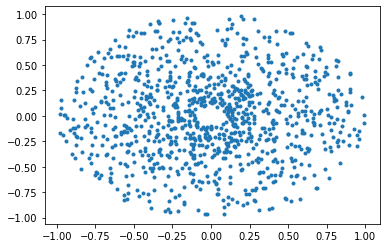

In [6]:
plt.plot(X[:,0].cpu(), X[:,1].cpu(), '.')

In [7]:
# Generate Positive pair
unif = Uniform(0, 2*math.pi)
thetas = unif.sample([1000,]).to(device)
X_p = torch.column_stack([r*torch.cos(th+thetas), r*torch.sin(th+thetas)])
X_p

tensor([[-0.7322, -0.1151],
        [ 0.4994, -0.1004],
        [ 0.5754, -0.0229],
        ...,
        [-0.3621, -0.6779],
        [ 0.2649,  0.0554],
        [ 0.1619,  0.3464]])

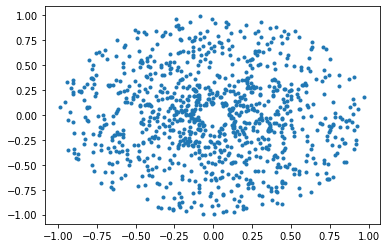

In [8]:
plt.plot(X_p[:,0].cpu(), X_p[:,1].cpu(), '.')

In [9]:
# Generate Negative pair
unif1 = Uniform(0.1, 1)
unif2 = Uniform(0, 2*math.pi)
r = unif1.sample([1000,]).float().to(device)
th = unif2.sample([1000,]).float().to(device)
X_n = torch.column_stack([r*torch.cos(th), r*torch.sin(th)])
X_n

tensor([[-0.4247,  0.5612],
        [-0.8024, -0.2431],
        [-0.2350,  0.0089],
        ...,
        [ 0.7022, -0.4344],
        [ 0.2892,  0.7896],
        [-0.6218,  0.5752]])

In [10]:
X_n

tensor([[-0.4247,  0.5612],
        [-0.8024, -0.2431],
        [-0.2350,  0.0089],
        ...,
        [ 0.7022, -0.4344],
        [ 0.2892,  0.7896],
        [-0.6218,  0.5752]])

In [11]:
# Labeling
y_p = torch.zeros((X_p.shape[0], 1))
y_n = torch.ones((X_n.shape[0], 1))
y = torch.vstack([y_p, y_n])
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

## Implement Dataset

In [12]:
# Implement Dataset
class RotationDataset(Dataset):
    def __init__(self, size):
        unif1 = Uniform(0.1, 1)
        unif2 = Uniform(0, 2*math.pi)
        unif3 = Uniform(0.1, 1)
        unif4 = Uniform(0, 2*math.pi)
        unif5 = Uniform(0, 2*math.pi)

        r1 = unif1.sample([size]).float()
        th1 = unif2.sample([size]).float()
        r2 = unif3.sample([size]).float()
        th2 = unif4.sample([size]).float()
        th3 = unif5.sample([size]).float()

        self.X = torch.column_stack([r1*torch.cos(th1), r1*torch.sin(th1)])
        X_p = torch.column_stack([r1*torch.cos(th1+th3), r1*torch.sin(th1+th3)])
        X_n = torch.column_stack([r2*torch.cos(th2), r2*torch.sin(th2)])

        self.X = torch.vstack([self.X, self.X])
        self.X_pair = torch.vstack([X_p, X_n])

        # Labeling
        y_p = torch.zeros((X_p.shape[0], 1))
        y_n = torch.ones((X_n.shape[0], 1))
        self.y = torch.vstack([y_p, y_n])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.Tensor(self.X[idx])
        x_pair = torch.Tensor(self.X_pair[idx])
        y = torch.Tensor(self.y[idx])
        return x, x_pair, y

## Implement Siamese Network

In [13]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(2,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.ReLU(),
        )

    def forward(self, x1, x2):
        out1 = self.linear_relu(x1)
        out2 = self.linear_relu(x2)
        return out1, out2

## Implement Contrastive Loss (Hadsell)

In [14]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

## Declare Model, Loss and Optimizer

In [15]:
net = SNN().to(device)
print(net)

SNN(
  (linear_relu): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): ReLU()
  )
)


In [16]:
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

## Make Dataset & Dataloader

In [17]:
train_dataset = RotationDataset(100000)
valid_dataset = RotationDataset(10000)

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=500)
dataloaders_dict = {
    "train": train_dataloader,
    "val": valid_dataloader,
}

In [19]:
for _, samples in enumerate(valid_dataloader):
    x, x_p, y = samples
    temp = torch.column_stack([x, x_p, y])
    print(temp[:5, :])
    break

tensor([[-0.1633, -0.0133,  0.1445, -0.0773,  0.0000],
        [ 0.7282, -0.1487,  0.7302, -0.1387,  0.0000],
        [ 0.1768,  0.3459,  0.2777, -0.2717,  0.0000],
        [-0.5143, -0.2273, -0.5447, -0.1395,  0.0000],
        [-0.5069,  0.0463,  0.4084,  0.3039,  0.0000]])


## Train & Validate

In [20]:
def train(net, dataloaders_dict, criterion, optimizer, num_epochs, dist=1):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("----------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corr = 0
            
            data = dataloaders_dict[phase]
            for batch, samples in enumerate(tqdm(data)):
                X, X_p, y = samples
                X, X_p, y = X.to(device), X_p.to(device), y.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    out1, out2 = net(X, X_p)
                    loss = criterion(out1, out2, y)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() + X.shape[0]
                    epoch_corr += torch.count_nonzero((torch.abs(out1 - out2) <= dist) != y).item()
                    
            epoch_loss = epoch_loss / len(data.dataset)
            epoch_acc = epoch_corr / len(data.dataset)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
                lr = scheduler._last_lr[0]
                print(f" Validation Loss: {epoch_loss:>8f}")
                print(f" Validation Acc : {epoch_acc:>8f}")
                print(f" Learning Rate  : {lr:>8f}\n")
                if lr < 1e-6:
                    return train_loss, val_loss
            
    return train_loss, val_loss

In [21]:
train_loss, val_loss = train(net, dataloaders_dict, criterion, optimizer, 500, 0.2)

  4%|▍         | 18/400 [00:00<00:02, 172.63it/s]

Epoch 1/500
----------------------


  6%|▌         | 22/400 [00:00<00:01, 214.64it/s]

 Validation Loss: 1.000245
 Validation Acc : 0.991200
 Learning Rate  : 0.010000

Epoch 2/500
----------------------


  4%|▍         | 17/400 [00:00<00:02, 165.81it/s]

 Validation Loss: 1.000194
 Validation Acc : 0.878600
 Learning Rate  : 0.010000

Epoch 3/500
----------------------


  6%|▌         | 22/400 [00:00<00:01, 218.75it/s]

 Validation Loss: 1.000146
 Validation Acc : 0.978050
 Learning Rate  : 0.010000

Epoch 4/500
----------------------


  6%|▌         | 23/400 [00:00<00:01, 221.90it/s]

 Validation Loss: 1.000124
 Validation Acc : 0.991850
 Learning Rate  : 0.010000

Epoch 5/500
----------------------


  6%|▌         | 23/400 [00:00<00:01, 221.12it/s]

 Validation Loss: 1.000117
 Validation Acc : 0.982250
 Learning Rate  : 0.010000

Epoch 6/500
----------------------


  5%|▌         | 20/400 [00:00<00:01, 192.72it/s]

 Validation Loss: 1.000106
 Validation Acc : 0.984500
 Learning Rate  : 0.010000

Epoch 7/500
----------------------


  6%|▋         | 25/400 [00:00<00:01, 242.93it/s]

 Validation Loss: 1.000102
 Validation Acc : 0.969250
 Learning Rate  : 0.010000

Epoch 8/500
----------------------


  6%|▌         | 24/400 [00:00<00:01, 236.28it/s]

 Validation Loss: 1.000095
 Validation Acc : 0.993150
 Learning Rate  : 0.010000

Epoch 9/500
----------------------


  6%|▌         | 24/400 [00:00<00:01, 232.15it/s]

 Validation Loss: 1.000093
 Validation Acc : 0.974300
 Learning Rate  : 0.010000

Epoch 10/500
----------------------


  5%|▌         | 20/400 [00:00<00:02, 179.46it/s]

 Validation Loss: 1.000082
 Validation Acc : 0.997000
 Learning Rate  : 0.001000

Epoch 11/500
----------------------


  4%|▍         | 17/400 [00:00<00:02, 165.81it/s]

 Validation Loss: 1.000081
 Validation Acc : 0.996900
 Learning Rate  : 0.001000

Epoch 12/500
----------------------


  3%|▎         | 11/400 [00:00<00:03, 106.23it/s]

 Validation Loss: 1.000082
 Validation Acc : 0.997000
 Learning Rate  : 0.001000

Epoch 13/500
----------------------


  6%|▌         | 23/400 [00:00<00:01, 224.06it/s]

 Validation Loss: 1.000081
 Validation Acc : 0.996900
 Learning Rate  : 0.001000

Epoch 14/500
----------------------


  6%|▌         | 23/400 [00:00<00:01, 222.15it/s]

 Validation Loss: 1.000082
 Validation Acc : 0.996750
 Learning Rate  : 0.001000

Epoch 15/500
----------------------


  5%|▌         | 20/400 [00:00<00:01, 198.07it/s]

 Validation Loss: 1.000079
 Validation Acc : 0.997000
 Learning Rate  : 0.001000

Epoch 16/500
----------------------


  5%|▌         | 20/400 [00:00<00:01, 199.72it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997050
 Learning Rate  : 0.000100

Epoch 17/500
----------------------


  5%|▌         | 21/400 [00:00<00:01, 202.39it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997000
 Learning Rate  : 0.000100

Epoch 18/500
----------------------


  5%|▌         | 21/400 [00:00<00:01, 202.21it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997100
 Learning Rate  : 0.000100

Epoch 19/500
----------------------


  5%|▌         | 21/400 [00:00<00:01, 202.53it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997050
 Learning Rate  : 0.000100

Epoch 20/500
----------------------


  5%|▌         | 21/400 [00:00<00:01, 203.62it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997000
 Learning Rate  : 0.000100

Epoch 21/500
----------------------


  5%|▌         | 21/400 [00:00<00:01, 203.87it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997100
 Learning Rate  : 0.000100

Epoch 22/500
----------------------


  4%|▍         | 15/400 [00:00<00:02, 147.23it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997000
 Learning Rate  : 0.000010

Epoch 23/500
----------------------


  4%|▍         | 18/400 [00:00<00:02, 172.44it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.996950
 Learning Rate  : 0.000010

Epoch 24/500
----------------------


  4%|▍         | 16/400 [00:00<00:02, 155.04it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997050
 Learning Rate  : 0.000010

Epoch 25/500
----------------------


  4%|▍         | 17/400 [00:00<00:02, 168.50it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997100
 Learning Rate  : 0.000010

Epoch 26/500
----------------------


  6%|▌         | 23/400 [00:00<00:01, 221.03it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997000
 Learning Rate  : 0.000010

Epoch 27/500
----------------------


  5%|▌         | 21/400 [00:00<00:01, 208.33it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997050
 Learning Rate  : 0.000010

Epoch 28/500
----------------------


  4%|▎         | 14/400 [00:00<00:02, 130.70it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997000
 Learning Rate  : 0.000001

Epoch 29/500
----------------------


  5%|▍         | 19/400 [00:00<00:02, 185.79it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.996950
 Learning Rate  : 0.000001

Epoch 30/500
----------------------


  5%|▌         | 21/400 [00:00<00:01, 207.58it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.996950
 Learning Rate  : 0.000001

Epoch 31/500
----------------------


  4%|▍         | 15/400 [00:00<00:02, 143.97it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997000
 Learning Rate  : 0.000001

Epoch 32/500
----------------------


  5%|▌         | 20/400 [00:00<00:01, 195.74it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997050
 Learning Rate  : 0.000001

Epoch 33/500
----------------------


  5%|▌         | 21/400 [00:00<00:01, 207.76it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997050
 Learning Rate  : 0.000001

Epoch 34/500
----------------------


100%|██████████| 40/40 [00:00<00:00, 258.01it/s]

 Validation Loss: 1.000078
 Validation Acc : 0.997000
 Learning Rate  : 0.000000



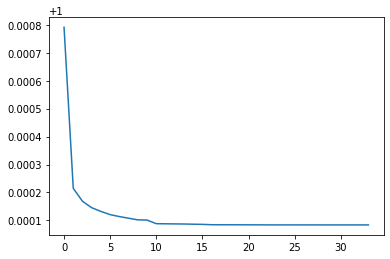

In [22]:
plt.plot(train_loss)
plt.show()

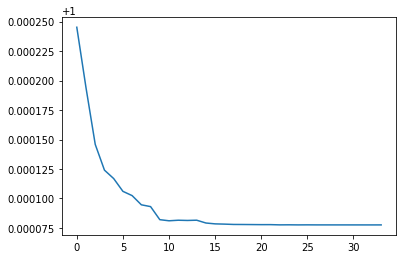

In [23]:
plt.plot(val_loss)
plt.show()

## Print Result & Save Model

In [24]:
with torch.no_grad():
    for X, X_p, y in train_dataloader:
        X, X_p, y = X.to(device), X_p.to(device), y.to(device)
        pred1, pred2 = net(X, X_p)
        data = torch.column_stack([pred1, pred2, y])
        print(data[:10,:])
        break

tensor([[24.5667, 24.5683,  0.0000],
        [54.0101, 37.7196,  1.0000],
        [29.7082, 29.7061,  0.0000],
        [64.4497, 45.7990,  1.0000],
        [24.3457, 39.1294,  1.0000],
        [16.0719, 56.5863,  1.0000],
        [21.8074, 44.4963,  1.0000],
        [44.6828, 57.8163,  1.0000],
        [66.0983, 66.1002,  0.0000],
        [53.9351, 53.9439,  0.0000]])


In [25]:
torch.save(net, "model/snn_rot10.pt")